<a href="https://colab.research.google.com/github/Yang-star-source/Deep-Image-Prior/blob/master/Deep_Image_Prior_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,dropout_prob = 0.0 ):
        super().__init__()
        self.norm1 = nn.GroupNorm(32,in_channels)
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        self.norm2 = nn.GroupNorm(32,out_channels)
        self.drop = nn.Dropout(dropout_prob)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        self.act = nn.LeakyReLU(0.2, inplace=True)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self,x):
        x1 = x

        x = self.norm1(x)
        x = self.act(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        return x + self.shortcut(x1)

class DownBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.res1 = ResNetBlock(in_channels,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)
        self.down = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=2,padding=1,padding_mode='reflect')

    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)

        skip_connection = x

        x = self.down(x)
        return x , skip_connection

class MidBlock(nn.Module):
    def __init__(self,in_channels):
        super().__init__()

        self.res1 = ResNetBlock(in_channels,in_channels)
        self.res2 = ResNetBlock(in_channels,in_channels)

    def forward(self,x):
        x = self.res1(x)
        x = self.res2(x)
        return x

class UpBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels,in_channels,kernel_size=3,padding=1,padding_mode='reflect')
        )
        # Why input *2 ? Because we have to concatenate the channels
        self.res1 = ResNetBlock(in_channels*2,out_channels)
        self.res2 = ResNetBlock(out_channels,out_channels)

    def forward(self,x,skip_connection):
        x = self.up(x)

        # cancatenate at channels dimension
        x = torch.cat([x,skip_connection],dim=1)
        x = self.res1(x)
        x = self.res2(x)
        return x

class Unet(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):
        super().__init__()

        self.init_conv = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,padding_mode='reflect')

        self.down1 = DownBlock(64,64)
        self.down2 = DownBlock(64,128)
        self.down3 = DownBlock(128,128)
        self.down4 = DownBlock(128,256)

        self.mid = MidBlock(256)

        self.up1 = UpBlock(256,128)
        self.up2 = UpBlock(128,128)
        self.up3 = UpBlock(128,64)
        self.up4 = UpBlock(64,64)

        self.out = nn.Sequential(
            nn.GroupNorm(32,64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,out_channels,kernel_size=3,padding=1,padding_mode='reflect')
        )

    def forward(self,x):

        x = self.init_conv(x)

        x1 , skip1 = self.down1(x)
        x2 , skip2 = self.down2(x1)
        x3 , skip3 = self.down3(x2)
        x4 , skip4 = self.down4(x3)

        x = self.mid(x4)

        x = self.up1(x,skip4)
        x = self.up2(x,skip3)
        x = self.up3(x,skip2)
        x = self.up4(x,skip1)

        x = self.out(x)
        return x




Epoch 900 | Loss 0.0002604398177936673


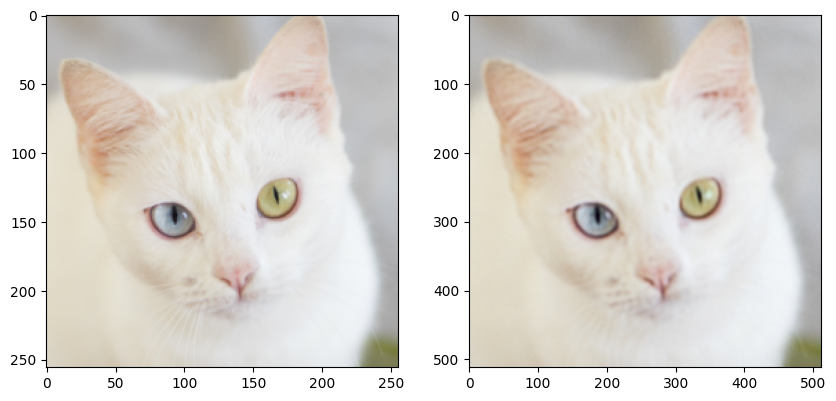

KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim import AdamW


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_PATH = "/content/drive/MyDrive/dataset/cat/0013.png"
img = Image.open(IMAGE_PATH).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

img = transform(img)
img = img.unsqueeze(0).to(DEVICE)
print(img.shape)
dataset_img = img

def plottable_clean_img(img):
    # Assume input shape (1,3,H,W)
    if img.dtype == torch.float32:
        img = img.detach().cpu().squeeze(0).permute(1,2,0).numpy()
        img = img * 0.5 + 0.5
        img = np.clip(img,0,1)
    return img

model = Unet().to(DEVICE)
optimizer = AdamW(model.parameters(),lr=0.0001)
EPOCH = 2000
z = torch.randn(1,3,512,512).to(DEVICE)

for epoch in range(EPOCH):
    optimizer.zero_grad()
    output = model(z)
    lower_resolution = F.interpolate(output,scale_factor=0.5,mode="bicubic")
    loss = F.mse_loss(lower_resolution,dataset_img)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        clear_output(wait=True)
        print(f"Epoch {epoch} | Loss {loss.item()}")
        fig , (ax_dataset , ax_high_reso) = plt.subplots(1,2,figsize=(10,5))
        ax_dataset.imshow(plottable_clean_img(dataset_img))

        ax_high_reso.imshow(plottable_clean_img(output))
        plt.show()


